In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

# 1. Reason for convolution

- Convolutional enforces weight sharing, and we want our model to have parameters independent of $|V|$
- Convolution enables detection of translational invariant and local features

In 1 dimensions, convolution is defined as
$$c[n] = (v * m)[n] = \sum_{m=0}^{N-1}v[m]w[n-m]$$  

In [19]:
def convolution(v, w):
    c = np.zeros(v.shape)
    for n in range(len(v)):
        for m in range(len(v)):
            c[n] += v[m] * w[n-m]
            
    return c

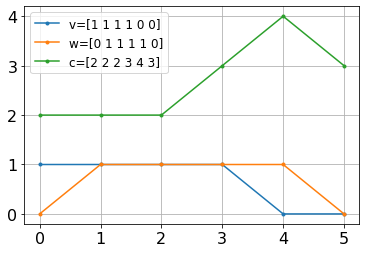

In [20]:
N = 6
v = np.zeros(N, dtype=np.uint32)
v[0:N//2+1] = 1
w = np.zeros(N, dtype=np.uint32)
w[1:N//2 + 2] = 1
c = convolution(v, w)
fig = plt.figure()
ax = fig.gca()
ax.plot(v, '.-')
ax.plot(w, '.-')
ax.plot(c, '.-')
ax.legend([f'v={v}', f'w={w}', f'c={c.astype(np.uint32)}'], prop={'size': 12})
ax.grid(True)

# 2. Fourier Transform

To go over the basics of the fourier transform, refer https://mathworld.wolfram.com/FourierTransform.html, though we show it's computation here.
Defining the transform over vectors as $\mathcal{F}: \mathbb{R}^N \to \mathbb{R}^N$ satsifying:
$$\mathcal{F}^{-1}(\mathcal{F}(\mathbf v)) = v $$
$$\mathcal{F}(v * w) = \mathcal{F}(v) \cdot \mathcal{F}(w)$$
The above two equations imply that $$v * w = \mathcal{F}^{-1}(\mathcal{F}(v) \cdot \mathcal{F}(w))$$

We construct the matrix $\mathbf{U}$ such that $\mathcal{F}(v) = \mathbf{U}v$ and $\mathcal{F}^{-1}(v) = \dfrac{1}{N}\mathbf{U}^Hv$ where $\mathbf{U}^H$ is the Hermitian (i.e conjugate transpose) of $\mathbf{U}$. <br>
The elements of $\mathbf{U}$ (0-indexed) are $\mathbf{U}[i,j] = u_j(i)$ where $u_n(x) = e^{-\iota 2 \pi \frac{n}{N}x}$

In [37]:
v, w = np.random.rand(N), np.random.rand(N)
c = convolution(v, w)
print(v)
print(w)
print(c)

[0.59691376 0.58322523 0.89621056 0.92752794 0.96754941 0.5162032 ]
[0.68346913 0.2480897  0.53020287 0.92660617 0.12861476 0.85615805]
[2.5230863  2.60352595 2.47057854 2.61337556 2.42571724 2.5011241 ]


In [38]:
from scipy.fft import fft, ifft
Fv = fft(v)
Fw = fft(w)
Fvw = Fv * Fw
IFc = ifft(Fvw)
print(f"F(v) = {Fv}\n")
print(f"F(w) = {Fw}\n")
print(f"F(v)F(w) = {Fvw}\n")
print(f"v * w = {np.abs(IFc)}")

F(v) = [ 4.48763012-0.j         -0.71277994+0.00373848j  0.0428475 -0.11982404j
  0.43371736-0.j          0.0428475 +0.11982404j -0.71277994-0.00373848j]

F(w) = [ 3.37314068-0.j         -0.02042198+0.17881714j  0.72854261+0.87438814j
 -0.68856715-0.j          0.72854261-0.87438814j -0.02042198-0.17881714j]

F(v)F(w) = [ 1.51374077e+01-0.j          1.38878728e-02-0.12753362j
  1.35988947e-01-0.04983158j -2.98643528e-01+0.j
  1.35988947e-01+0.04983158j  1.38878728e-02+0.12753362j]

v * w = [2.5230863  2.60352595 2.47057854 2.61337556 2.42571724 2.5011241 ]


In [39]:
def get_U(N):
    u = lambda n, N: np.cos(2 * np.pi * n / N * np.arange(N)) - 1j * np.sin(2 * np.pi * n / N * np.arange(N))
    U = np.empty((N, 0))
    for n in range(N):
        U = np.c_[U, u(n, N)]
    return U

def FT(v):
    N = v.shape[0]
    U = get_U(N)
    return U @ v

def IFT(v):
    N = v.shape[0]
    U = get_U(N)
    return (U.conj().transpose() @ v) / N

In [40]:
print(FT(v))

[ 4.48763012+0.00000000e+00j -0.71277994+3.73847820e-03j
  0.0428475 -1.19824041e-01j  0.43371736-3.48052324e-17j
  0.0428475 +1.19824041e-01j -0.71277994-3.73847820e-03j]


In [41]:
print(IFT(FT(v)))

[0.59691376-7.65591294e-16j 0.58322523+3.70074342e-17j
 0.89621056-7.40148683e-17j 0.92752794+2.91433544e-16j
 0.96754941+4.44089210e-16j 0.5162032 -3.51570624e-16j]


We can note that the functions $u_n(x)$ are the eigenvectors of the Laplacian, i.e
$$\Delta u_n(x) = -4\pi^2 \dfrac{n^2}{N^2}u_n(x) $$

We can simplify the operation notation as follows:
$$ v * w = \mathbf{U}^H ((\mathbf{U}w) \odot (\mathbf{U}v))$$
Defining the filter $g_w = diag(\mathbf{U}w)$, we can write
$$ v * w = \mathbf{U}^H g_w \mathbf{U}v$$

In [44]:
U = get_U(N)
print(c)
np.abs((U.conj().transpose() / N) @ ((U @ v) * (U @ w)))

[2.5230863  2.60352595 2.47057854 2.61337556 2.42571724 2.5011241 ]


array([2.5230863 , 2.60352595, 2.47057854, 2.61337556, 2.42571724,
       2.5011241 ])

# 3. Convolution on Graphs

Consider $G = (V, E)$ as an undirected, unweighted simple graph. For the graph-spectral theory we will look here, you can read the corresponding notes made by me @ [Graph-Representation-Learning](https://github.com/EeshaanJain/Graph-Neural-Nets/blob/main/Notes/Graph%20Representation%20Learning/main.pdf). Mainly, read section 2.4, though for completeness I will sum up theory here.

## a. Graph Laplacian
Let $\mathbf{A}$ be the adjacency matrix of the graph $G$, i.e $A_{ij} = 1$ if $(i,j) \in E$ else $A_{ij} = 0$. Define the degree matrix as $\mathbf{D}$ which is a diagonal matrix having the degrees of node on the diagonal, i.e $D_{ii} = deg(i)$.<br>
We define the unnormalized Laplacian as $$\mathbf{L} = \mathbf{D} - \mathbf{A}$$ and the symmetric normalized laplacian as 
$$\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1/2}\mathbf{A}\mathbf{D}^{-1/2}$$

## b. Graph Spectrum, Fourier transform, Convolution
The spectral decomposition of the Laplacian is given as $$\mathbf{L} = \mathbf{U}\mathbf{\Lambda}\mathbf{U}^T$$
Now, consider $v$ to be a feature vector of the graph, then $$\mathcal{F}(v) = \mathbf{U}v \qquad \qquad \mathcal{F}^{-1}(v) = \mathbf{U}^T v $$
Now consider the filter $\mathbf{U}w$. The convolution with this (considering $g_w = diag(\mathbf{U}^T w)$) can be written as
$$v * w = \mathbf{U}((\mathbf{U}^Tw) \odot \mathbf{U}^T v)) = \mathbf{U}g_w \mathbf{U^T}v$$ 

# 4. Spectral-Convolutional Layers in PyTorch-Geometric

Computation of spectrum is a global problem, and is expensive to calculate. We aim to implement the spectrum as message passing.

## a. ChebConv
This was introduced in [Convolutional Neural Networks on Graphs
with Fast Localized Spectral Filtering](https://arxiv.org/pdf/1606.09375.pdf). <br>
We want to implement $\mathbf{U} g_w \mathbf{U}^T x$ with $g_w = g_w(\mathbf{\Lambda})$ a filter.

**Chebyshev approximation** <br>
Chebyshv polynomials $T_k$ have the recurrence relation defined as:
$$ T_k(x) = 2xT_{k-1}(x) - T_{k-2}(x), \quad T_0(x) = 1, T_1(x) = x $$
For the filter, the following approximation exists:
$$g_w(\mathbf{\Lambda}) = \sum_{k=0}^K \theta_k T_k(\tilde{\mathbf\Lambda}) \quad \text{where} \quad \tilde{\mathbf\Lambda} = \dfrac{2}{\lambda_{\max}} \mathbf\Lambda - \lambda_{\max}\mathbf{I}$$
Now, note that if $\mathbf{L} = \mathbf{U}\mathbf{\Lambda}\mathbf{U}^T$, then $T_k(\mathbf{L}) = \mathbf{U}T_k(\mathbf{\Lambda})\mathbf{U}^T$, and this property gives rise to the fast-approximated convolution:
$$ 
\begin{split}
v * w &= \mathbf{U} g_w \mathbf{U}^T x = \mathbf{U}\bigg(\sum_{k=0}^K \theta_k T_k(\tilde{\mathbf\Lambda}) \bigg)\mathbf{U}^T x \\
&= \sum_{k=0}^K \theta_k \mathbf{U}T_k(\tilde{\mathbf\Lambda})\mathbf{U}^T x \\
&= \sum_{k=0}^K \theta_k T_k(\tilde{\mathbf L})x \quad \text{where} \quad \tilde{\mathbf L} = \dfrac{2}{\lambda_\max} \mathbf{L} - \mathbf{I}
\end{split}
$$

We notice that the equation doesn't depend on $\mathbf U$ or $\mathbf \Lambda$ but only on $\mathbf L$ and $\lambda_\max$. Also note that since we are using only $K$-powers, the filter takes in $K$-hop neighborhood of each node. <br>

The source code for the implementation of ChebConv in PyG is given here: [ChebConv](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/cheb_conv.html)

## b. GCNConv
This was introduced in [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/pdf/1609.02907.pdf). <br>
We start with **ChebConv** and make the following assumptions:
- $K = 1$, thus $$v * w = \theta_0x + \theta_1 \tilde{\mathbf L} x $$
- $\lambda_\max = 2$, and so $\mathbf{\tilde L} = \mathbf L - \mathbf I \implies$
 $$v * w = \theta_0x + \theta_1 (\mathbf{L} - \mathbf{I})x = \theta_0x - \theta_1 \mathbf{D}^{-1/2}\mathbf{A}\mathbf{D}^{-1/2} x$$
- $\theta_0 = -\theta_1 = \theta$, and thus $$v * w = (I + \mathbf{D}^{-1/2}\mathbf{A}\mathbf{D}^{-1/2})x\theta$$
- Renormalize $\theta$ using $$ \begin{split} 
\tilde{\mathbf A} &= \mathbf{I} + \mathbf{A} \\
\tilde{\mathbf D}_u &= \sum_j \tilde{A}_{ij} \\
\implies v * w &= (\mathbf{D}^{-1/2}\mathbf{A}\mathbf{D}^{-1/2})x\theta
\end{split}$$
If our $x$ is $F$-dimensional, and we want $F'$-dimensional output, then $\mathbf{\Theta'} \in \mathbb{R}^{F \times F'}$ and
$$ v * w = (\mathbf{D}^{-1/2}\mathbf{A}\mathbf{D}^{-1/2})x\mathbf\Theta $$

If we want a nodewise formulation, it is given as
$$ x_i' = \Theta \sum_{j \in \mathcal{N}(v) \cup \{i\}} \dfrac{e_{j,i}}{\sqrt{\hat{d}_j \hat{d}_i}} x_j $$ where $\hat{d}_i = 1 + \sum_{j \in \mathcal{N}(i)} e_{j, i}$ where $e_{j, i}$ denotes the edge weight for the edge from $j \to i$.